In [1]:
import pandas as pd
import numpy as np
import regex as re
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

# Import our text

In [2]:
# r = requests.get('https://finalfantasy.fandom.com/wiki/Final_Fantasy_VII_script')

# if r.status_code == 200:
#     html_content = r.text  # Get the text content of the response
#     with open('./ffvii_plot_text.html', 'w', encoding='utf-8') as file:
#         file.write(html_content)

In [3]:
with open ('./ffvii_plot_text.html', 'r', encoding='utf-8') as file:
    text = file.readlines()

In [4]:
count = 0 # Find the first and last lines in the main plot.
for line in text:
    if 'c\'mon newcomer' in line.lower() or 'five hundred' in line.lower():
        print(count)
    count+=1

2130
11593


In [5]:
text = text[2130:11594] # Remove text prior to the first line and 'Miscellaneous' text.
print(text[0], text[-1])

<p><b>Barret</b>: C'mon newcomer. Follow me.
 </p><p><b>On-screen</b>: Five hundred years later



In [6]:
# Remove unnecessary html tags.
html_content = ''.join(text)
soup = BeautifulSoup(html_content, 'html.parser')
text_without_tags = soup.get_text()
text_without_tags = text_without_tags.split('\n')

In [7]:
# Examine a character's dialogue.

character = 'Cloud'

def dialogue_lines(party_member: 'str'):
    lines = []
    for line in text_without_tags:
        if line.startswith(party_member):
            lines.append(line[len(party_member) + 2:])
    return lines

dialogue_lines(character)[:5] # Use 5 examples to make comparisons in subsequent cells.

['...Cloud.',
 "I don't care what your names are. Once this job's over...I'm outta here.",
 "No. After all, I did work for Shinra, y'know.",
 "I'm not here for a lecture. Let's just hurry.",
 "It's not my problem."]


&nbsp;
# Text Preprocessing


In [8]:
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS 

def clean_text(dialogue):
    tokens = [preprocess_string(string) for string in dialogue]
    tokens = [[string for string in token if string not in STOPWORDS] for token in tokens]
    return tokens

dialogue_tokens = clean_text(dialogue_lines(character))
dialogue_tokens[:5] # Compare with the above cell's output.

[['cloud'],
 ['care', 'job', 'outta'],
 ['work', 'shinra', 'know'],
 ['lectur', 'let', 'hurri'],
 ['problem']]

In [9]:
from gensim.models.phrases import Phrases, Phraser

def append_bigrams(dialogue):
    phrase_model = Phrases(dialogue_tokens, min_count=5)
    frozen_model = Phraser(phrase_model)
    for i, sentence in enumerate(dialogue_tokens):
        fm = frozen_model[sentence]
        for token in fm:
            if '_' in token:
                dialogue[i].append(token)
    return dialogue

dialogue_tokens = clean_text(dialogue_lines(character))
bigrams = append_bigrams(dialogue_tokens)
bigrams[:5] # Compare with the above cell's output.

[['cloud'],
 ['care', 'job', 'outta'],
 ['work', 'shinra', 'know'],
 ['lectur', 'let', 'hurri'],
 ['problem']]

In [10]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

def find_topics(tokens, num_topics):
    dictionary = Dictionary(tokens)
    dictionary.filter_extremes(no_below=3, no_above=0.5)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    lda_model = LdaModel(
        corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=10,
        alpha='auto',
        eta='auto',
        eval_every=None,
        random_state=7,
    )
    return lda_model.top_topics(corpus)

tokens = clean_text(dialogue_lines(character))
bigrams = append_bigrams(tokens)
find_topics(bigrams, num_topics=14)

[([(0.08633427, 'huge_materia'),
   (0.05464528, 'fight'),
   (0.05293006, 'know'),
   (0.048121724, 'huge'),
   (0.04136625, 'materia'),
   (0.039430436, 'shinra'),
   (0.03394742, 'soldier'),
   (0.03152471, 'save'),
   (0.028082583, 'planet'),
   (0.02755042, 'reason'),
   (0.026353724, 'aeri'),
   (0.022196881, 'war'),
   (0.022141766, 'meteor'),
   (0.017435197, 'want'),
   (0.016674282, 'big'),
   (0.016648566, 'kind'),
   (0.01652667, 'monster'),
   (0.016422603, 'fine'),
   (0.014000563, 'wear'),
   (0.012625431, 'let')],
  -14.095015003697785),
 ([(0.07673757, 'want'),
   (0.07280294, 'sephiroth'),
   (0.059770912, 'promis_land'),
   (0.052933395, 'materia'),
   (0.051894203, 'flashback'),
   (0.047944658, 'wai'),
   (0.040507533, 'land'),
   (0.03963625, 'promis'),
   (0.033969484, 'magic'),
   (0.026601547, 'button'),
   (0.020536093, 'gotta'),
   (0.01849783, 'beat'),
   (0.015992388, 'thing'),
   (0.015465624, 'let'),
   (0.015285051, 'stronger'),
   (0.015253204, 'notic')

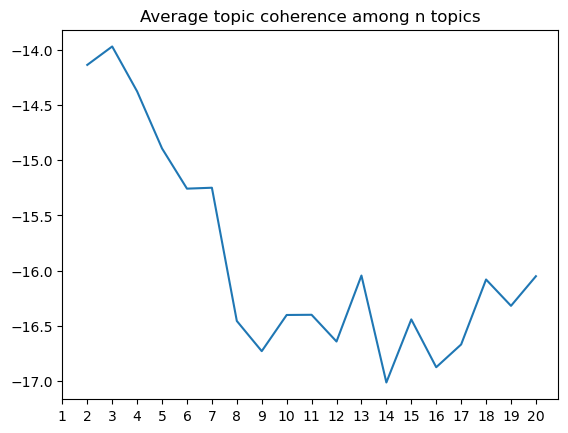

In [11]:
def calculate_avg_coherence(topics):
    avg_topic_coherence = None
    coherences = []
    for topic in topics:
        coherences.append(topic[-1])
    avg_topic_coherence = sum(coherences) / len(coherences)
    return avg_topic_coherence

def plot_coherences_topics(tokens):
    topics_range = range(2, 21, 1) # Start, Stop, Step.
    model_results = {'Topics': [],'Coherences': []}
    for i in topics_range:
        topics = find_topics(tokens, i)
        coherence_avg = calculate_avg_coherence(topics)
        model_results['Topics'].append(i)
        model_results['Coherences'].append(coherence_avg)
    plt.plot(pd.DataFrame(model_results).set_index('Topics'))
    plt.title('Average topic coherence among n topics')
    plt.xticks(np.arange(1, topics_range.stop))

tokens = clean_text(dialogue_lines(character))
bigrams = append_bigrams(tokens)
coherences_df = plot_coherences_topics(bigrams)


LDA tends to underperform on short-length documents. Would be interesting to compare results with models specifically intended for short-length text documents, e.g. 
-  [gsDMM](https://github.com/rwalk/gsdmm),
-  [NQTM](https://medium.com/professorbob/from-lda-to-short-text-topic-modeling-negative-sampling-and-quantization-topic-model-nqtm-3eabee5447a7#:~:text=From%20LDA%20to%20Short%20text%20topic%20modeling%20%E2%80%94,using%20example%20...%205%20Details%20in%20processing%3A%20)
-  [BTM](https://github.com/maximtrp/bitermplus),
-  [and others](https://github.com/qiang2100/STTM)
